# Goal
The goal of this notebook is to explore the correlation between new vulnerability discovery and a spike in open source software releases.

## Data
The `"release.csv"` dataset contains information pertaining to new software releases among open source software.
The NVD data sets contain information about vulnerabilities

##### Schema
The dataset contains the following columns:
`'id', 'target', 'date', 'date_offset', 'name', 'comment', 'author'`

Some fields relate to a handful of other datasets (directory info, snapshots, servers). The extra data is unnseccecary for our purposes.

## Challenges
##### Large Dataset
The full dataset is large (1.4 Gigs). A teaser dataset is being used to explore properties of the data.
##### Unclear Connection
We wish to compare this dataset with another set, NVD, which contains information about discovered software vulnerabilities.
It may be possible to directly relate and connect the two datasets. This requires exploring of the two sets.

Alternatively, we can always correlate the two.





## Project Review 2

Explore the correlation between vulnerability publish and spike in frequency.


# Code
Simple imports

Declaring column headers and path to the data (on my machine)

In [53]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = [16,9]

# Releases

In [2]:
release_header = ['id', 'target', 'date', 'date_offset', 'name', 'comment', 'author']
revision_header = ['id', 'date', 'committer_date', 'directory', 'message', 'author', 'committer']
# Path to release.csv, and whether to select uncompressed or ocmpressed version
# release_path = 'D:/data/open_source/release.csv'
release_path = 'D:/data/open_source/release.csv.gz'

Some fields are stored as hexidecimal strings, this function converts it to decimal.

Also, a function to convert the incoming date string to a dateitme object.

In [3]:
def hex_str(str):
    return bytes.fromhex((str).replace('\\x','')).decode('utf-8')

def date_str(str):
    return pd.to_datetime(str, format='%Y-%m-%dT%H:%M:%S.000Z')

The data is read in and only the useful columns are kept

In [4]:
release_df = pd.read_csv(release_path, names=release_header, converters={'date':date_str,'comment':hex_str})
release_df = release_df[['id','date','name','comment','author']]

This function allows resample of the releases

In [5]:
def releases_resample(resample_by):
    return (release_df[['date','id']].set_index('date').resample( resample_by ).count()).rename(columns={'id':'count'})

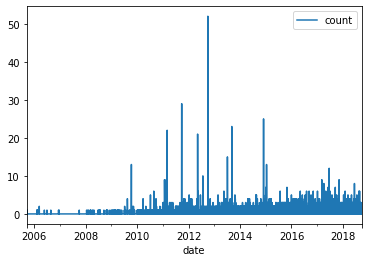

In [6]:
r_h = releases_resample('H')
r_h.plot()

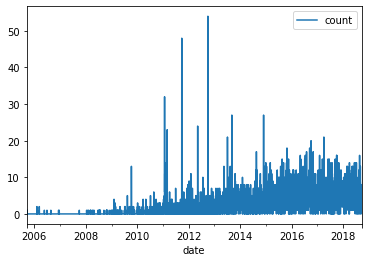

In [7]:
r_d = releases_resample('d')
r_d.plot()

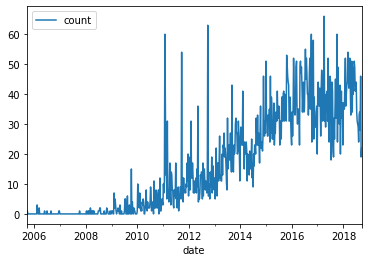

In [8]:
r_w = releases_resample('w')
r_w.plot()

In [9]:
r_d.head()

,count
date,
2005-09-16,1
2005-09-17,0
2005-09-18,0
2005-09-19,1
2005-09-20,0


Here we see spikes in the data. This may be erreoneous data.

It is possible that these spikes in `dayly` release rate is due to a response to an extreme vulnerability. This could also be due to various other factors, such as github/others servers crashing, and only pushing releases after coming back online.

# National Vulnerability Dataset
NVD Files available for download at https://nvd.nist.gov/vuln/data-feeds

In [10]:
# Path to nvd file directory
nvd_dir = 'D:/data/open_source/NVD/'

# Select file type to load
# nvd_file_type = '.json'
nvd_file_type = '.json.zip'
# nvd_file_type = '.json.gz'

In [11]:
def date_str_nvd(st):
    return pd.to_datetime( st, format='%Y-%m-%dT%H:%MZ')

def score_nvd(json):
    if json['impact'] and 'baseMetricV2' in json['impact']:
        return json['impact']['baseMetricV2']['cvssV2']['baseScore']
    else:
        return 0.0

Gather all NVD Datasets into one dataframe

In [12]:
def import_nvd(nvd_start=2, nvd_end=19):
    
    for i in range(nvd_start,nvd_end):
        
        year = '20'+str(i).zfill(2)
        path = nvd_dir+'nvdcve-1.1-'+year+nvd_file_type
        if i==nvd_start:
            nvd = pd.read_json(path, encoding="utf8")
        else:
            nvd = nvd.append( pd.read_json(path, encoding="utf8") )
    nvd = nvd.reset_index()
    return nvd.drop(['index'], 1)

def import_nvd_clean(nvd_start=2, nvd_end=20):
    
    for i in range(nvd_start,nvd_end):
        
        year = '20'+str(i).zfill(2)
        path = nvd_dir+'nvdcve-1.1-'+year+nvd_file_type
        if i==nvd_start:
            nvd = clean_nvd(pd.read_json(path, encoding="utf8"))
        else:
            nvd = nvd.append( clean_nvd(pd.read_json(path, encoding="utf8")) )
    nvd = nvd.reset_index()
    return nvd.drop(['index'], 1)
    


def clean_nvd(nvd):
    nvd['date'] = nvd['CVE_Items'].apply( lambda x: date_str_nvd(x['publishedDate']) )
    nvd['score'] = nvd['CVE_Items'].apply( lambda x: score_nvd(x) )
    new_nvd = nvd.drop(['CVE_data_type','CVE_data_format','CVE_data_version','CVE_data_numberOfCVEs','CVE_data_timestamp','CVE_Items'], 1)
    return new_nvd

`nvd` contains all NVD Vulnerability information
Not much of it is needed, and takes a lot of memory.

In [13]:
#nvd = import_nvd(15,16)

In [14]:
#nvd.head()

Nearly all useful information (date and score) is held within the JSON object in the `CVE_Items` tab.

In [15]:
#nvd['CVE_Items'][1]

All vulnerabilities within NVD have a published date accessible by

In [16]:
#nvd['CVE_Items'][1]['publishedDate']

Along with a vulnerability score, accessible by

In [17]:
#nvd['CVE_Items'][1]['impact']['baseMetricV2']['cvssV2']['baseScore']

Some (around 10% of) vulnerabilities have no vulnerability information. They are given a score of 0.0 (for now)

In [18]:
#nvd['CVE_Items'][25]#['impact']['baseMetricV2']['cvssV2']['baseScore']

`clean_nvd` imports NVD, but only keeps the important columns.
`date` (date vulnerability was published) and `score` (A measure of the severity and impact of the vulnerability 0.0-10.0). Most all other columns are removed, as they are not needed.

In [19]:
nvd_clean = import_nvd_clean()

In [20]:
nvd_clean.head()

,date,score
0,1999-12-30 05:00:00,5.0
1,1998-10-12 04:00:00,10.0
2,1998-04-01 05:00:00,10.0
3,1997-12-16 05:00:00,5.0
4,1998-07-20 04:00:00,10.0


Number of vulnerabilities given score of 0.0 since they had no vulnerability information

In [21]:
nvd_clean[ nvd_clean.score == 0.0].shape[0]

7257

In [22]:
def vulnerability_resample(resample_by):
    return (nvd_clean[['date','score']].set_index('date').resample(resample_by).count()).rename(columns={'score':'count'})

In [23]:
v_h = vulnerability_resample('h')
v_d = vulnerability_resample('d')

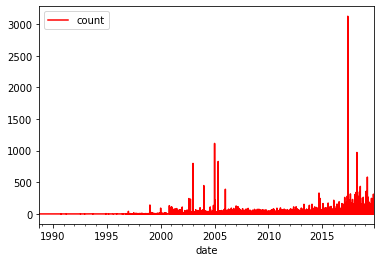

In [24]:
v_d.plot(color="red")

# Correlation Between Release and NVD

We next explore if there is a correlation between vulnerability publish date and spike in frequency

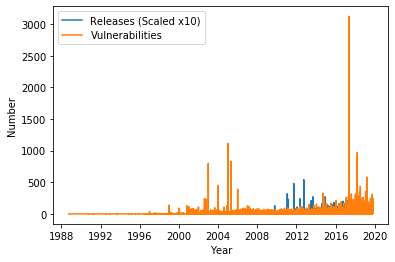

In [25]:
plt.plot(r_d*10, label="Releases (Scaled x10)")
plt.plot(v_d, label="Vulnerabilities")
plt.legend()
plt.xlabel("Year")
plt.ylabel("Number")
plt.show()

#### Exploring basic correlation
Weekly resampling of releases and vulnerabilities

In [26]:
r_w = releases_resample('w')
v_w = vulnerability_resample('w')

Correlation between the sets on daily and weekly basis is calculated

In [27]:
print( r_d['count'].corr(v_d['count']) )
print( r_w['count'].corr(v_w['count']) )

0.13784265436333917
0.2925604121743066


There could potentially be a relationship between vulnerability release and rise in release frequency. Weekly is likely higher as patches are not releases the same day, generally.

These functions are used in the next part of the analysis. They get ranges of dates and calculate the number of releases.

In [28]:
def get_delta_date(date, days):
    return (pd.to_datetime(date) + pd.Timedelta(days=days))
    # return np.datetime64((pd.to_datetime(date) + pd.Timedelta(days=days)), 'D')

def get_range(rel_df, start_date, end_date):
    return rel_df[rel_df.date > start_date][rel_df.date < end_date]
   
def get_count(rel_df):
    return rel_df['count'].sum()

def get_range_count(rel_df, start_date, end_date):
    return get_count( get_range(rel_df, start_date, end_date) )

def get_period(rel_df, date, days):
    start_date = get_delta_date(date, -days)
    end_date = get_delta_date(date, days)
    return get_range(rel_df, start_date, end_date)

def get_period_count(rel_df, date, days):
    return get_count(get_priod(rel_df, date, days))
    
def get_period_avg(rel_df, date, days):
    return get_count( get_period(rel_df, date, days) ) / (2*days)

def get_prev_avg(rel_df, date, days):
    return get_count( get_range(rel_df, get_delta_date(date, -days), date ) ) / days

def get_next_avg(rel_df, date, days):
    return get_count( get_range(rel_df, date, get_delta_date(date, days) ) ) / days

def get_delta_avg(rel_df, date, days):
    return get_next_avg(rel_df, date, days) - get_prev_avg(rel_df, date, days)

# Hypothesis Testing

# Hypothesis
## Weeks with a higher number of severe vulnerabilities have an increased frequency in releases.

As I am only exploring number of vulnerabilities per week, I will contain myself to only **severe** vulnerabilities, score 9.0 and up.

In [29]:
severe_vuln = nvd_clean[ nvd_clean.score >= 9.0]

Since the number of releases is not consistent with time, as GitHub is continually growing in popularity, we will select a segment of time with consitent number of releases.
This is around the year 2017.

January 1st, 2016 to January 1st, 2018  is analyzed.

In [30]:
date = '2017-01-01'
period = 365

In [31]:
severe_17 = get_period(severe_vuln, date, days=period)
severe_17

,date,score
36577,2017-11-07 21:29:00,10.0
43304,2017-04-13 16:59:00,9.3
45640,2017-03-11 06:59:00,9.3
46619,2016-05-13 10:59:00,10.0
47037,2017-08-17 16:29:00,9.0
...,...,...
105803,2017-07-17 21:29:00,10.0
105814,2017-06-23 22:29:00,10.0
105843,2017-08-05 17:29:00,10.0
105844,2017-08-05 17:29:00,9.0


In [32]:
r_d = releases_resample('d').reset_index()
releases_2017 = get_period(r_d, date, days=period)
releases_2017

,date,count
3761,2016-01-03,1
3762,2016-01-04,7
3763,2016-01-05,4
3764,2016-01-06,5
3765,2016-01-07,5
...,...,...
4485,2017-12-27,2
4486,2017-12-28,4
4487,2017-12-29,6
4488,2017-12-30,2


# Frequency in Releases

### The general trend in releases in this timeframe is constant.

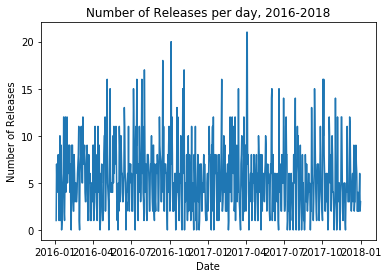

In [33]:
plt.plot(releases_2017['date'], releases_2017['count'], color="C0")

plt.title('Number of Releases per day, 2016-2018')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.show()

...As compared to the entire release dataset, which has a clear upward trend.

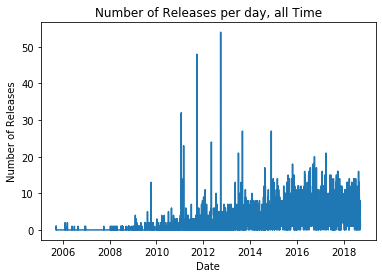

In [34]:
plt.plot(r_d['date'], r_d['count'], color="C0")

plt.title('Number of Releases per day, all Time')
plt.xlabel('Date')
plt.ylabel('Number of Releases')
plt.show()

In [35]:
# Convert datetime to unix time
# rel_17_n = releases_2017.set_index('date')
# rel_17_n.index = rel_17_n.index.values.astype(np.int64) // 10 ** 9
# coefs = np.polyfit(rel_17_n.index, rel_17_n.values, 1)
# linefit = np.poly1d([coefs[1][0],coefs[0][0]])
# fig=plt.figure()
# ax=fig.add_subplot(111, label="1")
# ax2=fig.add_subplot(111, label="2", frame_on=False)
# ax.plot(releases_2017['date'], releases_2017['count'], color="C0")
# ax2.scatter(rel_17_n.index, linefit(rel_17_n.index ), color="C1")
# ax.axes.get_xaxis().set_ticks([])
# ax.axes.get_yaxis().set_ticks([])
# ax2.axes.get_xaxis().set_ticks([])
# ax2.axes.get_yaxis().set_ticks([])
# ax2.set_ylim([0,10e10])
# print(coefs)
# print(linefit(rel_17_n.index))

### Between 2016 and 2018, the median number of releases per day was 5.
The mean and median number of releases per day are found.
The median will be taken to reduce the impact that outliers have.


In [36]:
rel17_mean = releases_2017['count'].mean()
rel17_med = releases_2017['count'].median()

print( rel17_mean )
print( rel17_med )

5.403292181069959
5.0


In [37]:
num_rel_daily = severe_17['date'].apply(lambda x: get_next_avg(releases_2017, x, days=7))

In [38]:
print( num_rel_daily.mean() )
print( num_rel_daily.median() )

5.309795213422157
5.142857142857143


In [39]:
sev17_w = severe_17.set_index('date').resample('w').count().reset_index()
sev17_w

,date,score
0,2016-01-03,2
1,2016-01-10,14
2,2016-01-17,34
3,2016-01-24,13
4,2016-01-31,13
...,...,...
100,2017-12-03,17
101,2017-12-10,95
102,2017-12-17,13
103,2017-12-24,25


### Between 2016 and 2018, the median number of vulnerabilities published per day was 18.
The mean and median number of publishes per day are found.
The median will be taken to reduce the impact that outliers have.

In [40]:
sev17_w_mean = sev17_w['score'].mean()
sev17_w_med = sev17_w['score'].median()

print( sev17_w_mean )
print( sev17_w_med )

27.571428571428573
18.0


# Publishes per Week vs. Releases per Week

Get the number of releases within each week

In [42]:
rel17_w = releases_2017.set_index('date').resample('w').sum().reset_index()
rel17_w

,date,count
0,2016-01-03,1
1,2016-01-10,34
2,2016-01-17,26
3,2016-01-24,34
4,2016-01-31,52
...,...,...
100,2017-12-03,36
101,2017-12-10,41
102,2017-12-17,32
103,2017-12-24,37


Get the average number of re

In [59]:
rel_avg_next_week = sev17_w['date'].apply(lambda x: get_next_avg(releases_2017, x, days=14))
rel_avg_nxt = rel17_w
rel_avg_nxt['count'] = rel_avg_next_week * 14
rel_avg_nxt

,date,count
0,2016-01-03,59.0
1,2016-01-10,55.0
2,2016-01-17,79.0
3,2016-01-24,93.0
4,2016-01-31,75.0
...,...,...
100,2017-12-03,70.0
101,2017-12-10,67.0
102,2017-12-17,57.0
103,2017-12-24,23.0


The two weekly datasets are meged. This allows us to plot the number of vulnerabilities discovered in a week and the number of releases the following two week.

In [55]:
weekly = pd.merge(sev17_w, rel17_w, on='date')

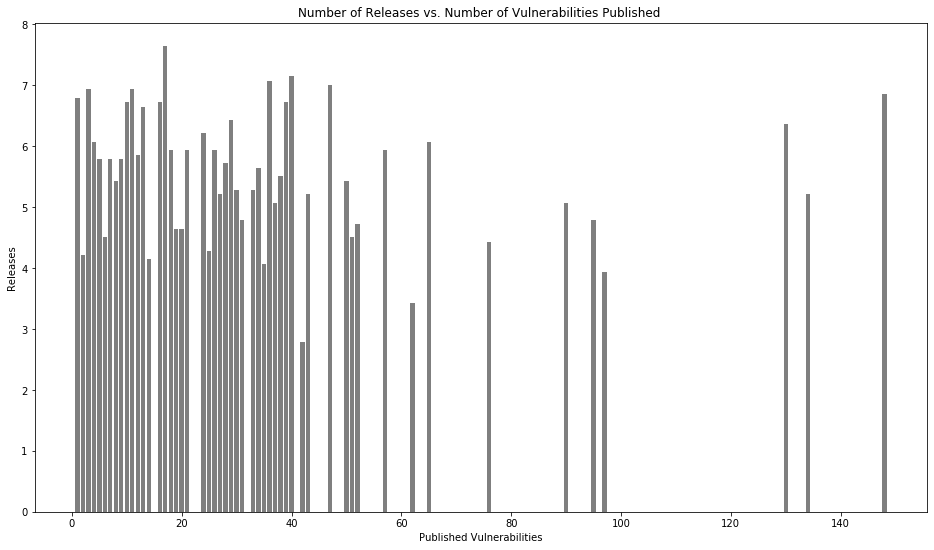

In [56]:
plt.bar(weekly['score'], weekly['count'], color='C7')
plt.title('Number of Releases vs. Number of Vulnerabilities Published ')
plt.xlabel('Published Vulnerabilities')
plt.ylabel('Releases')
plt.show()

In [60]:
weekly_nxt_avg = pd.merge(sev17_w, rel_avg_nxt, on='date')

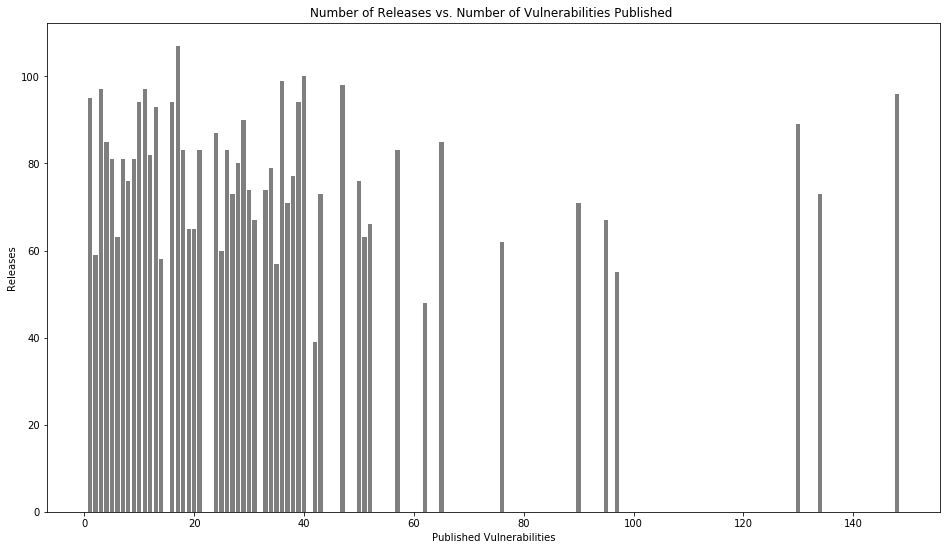

In [61]:
plt.bar(weekly_nxt_avg['score'], weekly_nxt_avg['count'], color='C7')
plt.title('Number of Releases vs. Number of Vulnerabilities Published ')
plt.xlabel('Published Vulnerabilities')
plt.ylabel('Releases')
plt.show()

# Exploration

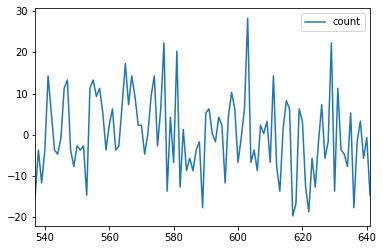

In [49]:
r17_w = get_period(r_w.reset_index(), '2017-01-01', 365)
r_diff = r17_w['count'].apply( lambda x: x - r17_w.mean())
r_diff.plot()

## Distribution of severity (NVD Score) of all vulnerabilities.

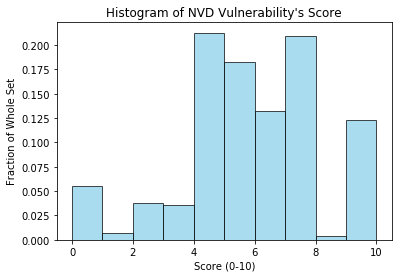

In [50]:
plt.hist(nvd_clean['score'].values, bins=10, density=True,linestyle='solid', color = "skyblue",alpha=0.7, ec="black")

plt.xlabel('Score (0-10)')
plt.ylabel('Fraction of Whole Set')
plt.title('Histogram of NVD Vulnerability\'s Score')
plt.show()

Seeing as their is quite a few 10.0 (maximum rating) it is no wonder people don't take these seiously!